[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/data_augmentation_sequential.ipynb)

# Augmentation Sequential

In this tutorial we will show how we can quickly perform **data augmentation for various tasks** (segmentation, detection, regression) using the features provided by the `kornia.augmentation.AugmentationSequential` API.

## Install and get data

We install Kornia and some dependencies, and download a simple data sample

In [1]:
%%capture
!wget https://tinypng.com/images/social/website.jpg -O panda.jpg

/home/edgar/software/kornia/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


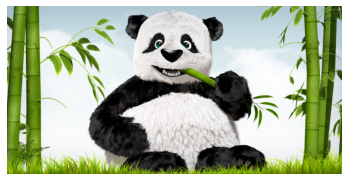

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import cv2

from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from kornia.geometry import bbox_to_mask
from kornia.utils import image_to_tensor, tensor_to_image
from torchvision.transforms import transforms

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

def plot_resulting_image(img, bbox, keypoints, mask):
    img = img * mask
    img_draw = cv2.polylines(np.array(to_pil(img)), bbox.numpy(), isClosed=True, color=(255, 0, 0))
    for k in keypoints[0]:
        img_draw = cv2.circle(img_draw, tuple(k.numpy()[:2]), radius=6, color=(255, 0, 0), thickness=-1)
    return img_draw

img = cv2.imread("panda.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

img_tensor = image_to_tensor(img).float() / 255.
plt.imshow(img); plt.axis('off');

## Define Augmentation Sequential and Different Labels

/home/edgar/software/tutorials/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


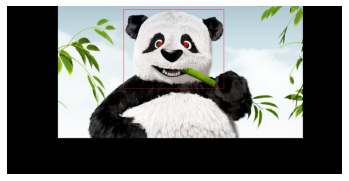

In [3]:
aug_list = AugmentationSequential(
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=1.0),
    K.RandomAffine(360, [0.1, 0.1], [0.7, 1.2], [30., 50.], p=1.0),
    K.RandomPerspective(0.5, p=1.0),
    data_keys=["input", "bbox", "keypoints", "mask"],
    return_transform=False,
    same_on_batch=False,
)

bbox = torch.tensor([[[355,10],[660,10],[660,250],[355,250]]])
keypoints = torch.tensor([[[465, 115], [545, 116]]])
mask = bbox_to_mask(torch.tensor([[[155,0],[900,0],[900,400],[155,400]]]), w, h).float()

img_out = plot_resulting_image(img_tensor, bbox, keypoints, mask)
plt.imshow(img_out); plt.axis('off');

## Forward Computations

/home/edgar/software/tutorials/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


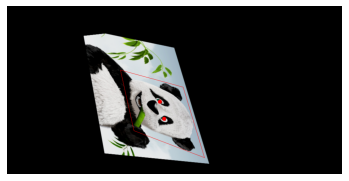

In [4]:
out_tensor = aug_list(img_tensor, bbox.float(), keypoints.float(), mask)
img_out = plot_resulting_image(
    out_tensor[0][0],
    out_tensor[1].int(),
    out_tensor[2].int(),
    out_tensor[3][0],
)
plt.imshow(img_out); plt.axis('off');

## Inverse Transformations

/home/edgar/software/tutorials/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


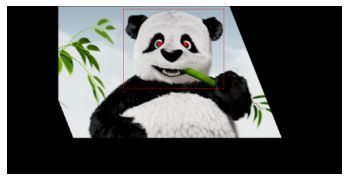

In [5]:
out_tensor_inv = aug_list.inverse(*out_tensor)
img_out = plot_resulting_image(
    out_tensor_inv[0][0],
    out_tensor_inv[1].int(),
    out_tensor_inv[2].int(),
    out_tensor_inv[3][0],
)
plt.imshow(img_out); plt.axis('off');